In [2]:
cd /content/drive/My Drive/Colab Notebooks/UNet_brain_mri

/content/drive/My Drive/Colab Notebooks/UNet_brain_mri


In [3]:
import os
import numpy as np
import time
import pandas as pd
import numpy as np
import cv2

import torch
from torch.optim import Adam, SGD
import torch.utils.data as data
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from utils.dataloader import make_datapath_list, DataTransform, BrainDataset

In [5]:
rootpath = os.path.abspath("")
makepath = make_datapath_list(rootpath)
train_img_list, train_anno_list = makepath.get_list("train")
val_img_list, val_anno_list = makepath.get_list("val")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


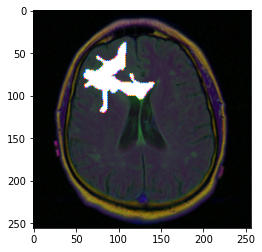

In [6]:
train_dataset = BrainDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(input_size=256))

val_dataset = BrainDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(input_size=256))

i = 6
img = train_dataset.__getitem__(i)[0]
img = img.clone().numpy()
img = img.transpose((1,2,0))
anno = train_dataset.__getitem__(i)[1]
anno = anno.clone().numpy()*255
anno = cv2.cvtColor(anno, cv2.COLOR_BAYER_BG2BGR)
anno = np.asarray(anno, np.float64)
blended_img = cv2.addWeighted(src1=img, alpha=0.8, src2=anno, beta=0.2, gamma=0)
plt.imshow(blended_img)
plt.show()

In [7]:
batch_size = 8
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
from utils.unet import Unet256, DiceBCELoss

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Unet256((3, 256, 256)).to(device)
model

Unet256(
  (down1): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(12, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(12, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (down2): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(24, eps=0.0001, momentum=0.1, a

In [10]:
criterion = DiceBCELoss()


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
epochs = 25


train_loss = []
val_loss = []

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    
    for image,mask in train_dataloader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
                              

    else:           
        running_val_loss = []
        
        with torch.no_grad():
            for image,mask in val_dataloader:
                image = image.to(device,dtype=torch.float)
                mask = mask.to(device,dtype=torch.float)                         
                pred_mask = model.forward(image)
                loss = criterion(pred_mask,mask)
                running_val_loss.append(loss.item())
                    

    if (epoch+1) % 5 == 0:
      torch.save(model.state_dict(), 'weights/Unet_model_'+str(epoch+1)+'.pth')
      
    epoch_train_loss = np.mean(running_train_loss) 
    print('Train loss: {}'.format(epoch_train_loss))                       
    train_loss.append(epoch_train_loss)
    
    epoch_val_loss = np.mean(running_val_loss)
    print('Validation loss: {}'.format(epoch_val_loss))                                
    val_loss.append(epoch_val_loss)
                      
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/25


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.5916296564421412
Validation loss: 0.47542448795360065
91m 23s
Epoch 2/25
Train loss: 0.35899103767538476
Validation loss: 0.37396598834058514
2m 9s
Epoch 3/25
Train loss: 0.2774343940371511
Validation loss: 0.3405019112903139
2m 9s
Epoch 4/25
Train loss: 0.23540573190413627
Validation loss: 0.3521638953167459
2m 8s
Epoch 5/25
Train loss: 0.2305987203483191
Validation loss: 0.3251506841161113
2m 9s
Epoch 6/25
Train loss: 0.21316648322015497
Validation loss: 0.34734508578760037
2m 8s
Epoch 7/25
Train loss: 0.20424653238769475
Validation loss: 0.3314241292899933
2m 8s
Epoch 8/25
Train loss: 0.22111199192155553
Validation loss: 0.321533404884563
2m 7s
Epoch 9/25
Train loss: 0.20387812333423538
Validation loss: 0.3159543311466341
2m 7s
Epoch 10/25
Train loss: 0.19595442774395147
Validation loss: 0.3184180857370729
2m 7s
Epoch 11/25
Train loss: 0.19797340412176934
Validation loss: 0.31528307735056116
2m 6s
Epoch 12/25
Train loss: 0.19637200379438993
Validation loss: 0.315583695

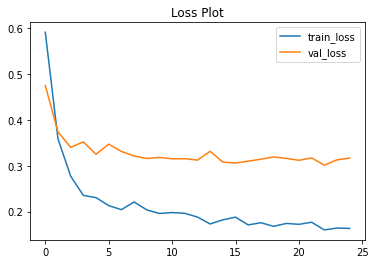

In [12]:
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.show()